# Plots simulation study

> **Objective.** Monte Carlo experiment for testing stable space estimation
- Dimension
- Stable space
- Projection Error

> **Methods**
- Johansen's Procedure
- PLS
- PCA

First, charge libraries and scripts

In [1]:
# scripts and libraries
remove(list = ls())
options(warn = -1)
library(data.table)
library(magrittr)
library(ggplot2)
library(latex2exp)
library(xtable)

source("../source/simulations.R")
source("../source/vectorial_methods.R")
source("../source/auxiliar_methods.R")

Experiment parameters

In [2]:
Tt <- 100 # series length
m <- 6 # series' dimension
r <- 4 # stable space's dimension
case <- 1 # scenario to consider
S <- 500 # number of simulations
crit <- "SC(n)" # criterio Johansen estimation
ec_det <- "none" # non trend and seasonality for Johansen procedure
pct <- "5pct" # Johansen's significance level
test <- "kpss" # test to use in PLS o PCA options: "adf" and "kpss"
persistence <- "low" ; dist <- "t" # persistence and innovation process distribution
trend <- FALSE # consider a simple linear trend
dependence <- TRUE # if we consider a covariance structure in the innovation process
seeds <- c(1,1) # seeds for reproducibility
sigma <- 1 # equal variance for the non-correlated case
methods_colors <- c("Johansen" = "#fa9f99","PLS" = "#4dcf74", "PCA" = "#90baff") 

`S` simulations with the above characteristics

In [3]:
# Results storage
n_coint <- matrix(NA, S, 3)
n_norms <- matrix(NA, S, 3)
colnames(n_coint) <- c("Johansen", "PLS", "PCA")
colnames(n_norms) <- c("Johansen", "PLS", "PCA")

# Shared Sigma_eps
set.seed(seeds[1])  # for reproducibility
if (dependence) {
  Sigma_eps <- clusterGeneration::genPositiveDefMat(m, covMethod = "eigen")$Sigma
} else {
  Sigma_eps <- sigma * diag(1, m, m)
}

# Shared stable basis
set.seed(seeds[2]+r)  # shared seed for beta, beta_orto, alpha, gamma
I_m <- qr.Q(qr(matrix(rnorm(m^2), m, m)))
beta <- I_m[, 1:r]
beta_orto <- if (r < m) I_m[, (r + 1):m] else matrix(0, m, m)

# Alpha and gamma
alpha <- if (persistence == "low") runif(r, 0.1, 0.3) else runif(r, 0.3, 0.7)
gamma <- runif(ncol(beta_orto), -0.7, 0.7)

# Integration orders by case
orders <- switch(
  as.character(case),
  "1" = c(m, 0),
  "2" = c(m - 3, 2),
  stop("Unsupported case")
)
i1 <- orders[1]
i2 <- orders[2]

# Simulation loop
for (s in 1:S) {
  # Epsilon innovations
  set.seed(s)
  epsilon <- if (dist == "normal") {
    if (trend) {
      portes::varima.sim(n = Tt + 100, k = m, sigma = Sigma_eps, trend = rep(0.05, m), demean = rep(0, m))
    } else {
      portes::varima.sim(n = Tt + 100, k = m, sigma = Sigma_eps, demean = rep(0, m))
    }
  } else if (dist == "t") {
    if (trend) {
      portes::varima.sim(n = Tt + 100, k = m, sigma = Sigma_eps, trend = rep(0.05, m), innov.dist = "t", dft = 3, demean = rep(0, m))
    } else {
      portes::varima.sim(n = Tt + 100, k = m, sigma = Sigma_eps, innov.dist = "t", dft = 3, demean = rep(0, m))
    }
  }

  # Simulate X using the improved core
  X_sim <- X_simulation(seed = s,
    m = m, r = r, Tt = Tt + 100,
    beta = beta, beta_orto = beta_orto,
    alpha = alpha, gamma = gamma, Sigma_eps = Sigma_eps,
    mix = TRUE, dist = dist, trend = trend)(i1,i2)

  beta_teo <- X_sim$beta
  X <- ts(scale(X_sim$X[101:nrow(X_sim$X), ]))  # remove burn-in
  XX <- X[1:(nrow(X) - 1), ]
  Y <- X[2:nrow(X), ]

  # PLS and PCA
  basis_PLS <- basis_stable(X, method = "pls", test = test)
  basis_PCA <- basis_stable(XX, method = "pca", test = test)

  if (!is.null(ncol(basis_PLS$basis_S))) {
    n_coint[s, "PLS"] <- ncol(basis_PLS$basis_S) - r
    n_norms[s, "PLS"] <- grassmann_distance(beta_teo, basis_PLS$basis_S)
  }
  if (!is.null(ncol(basis_PCA$basis_S))) {
    n_coint[s, "PCA"] <- ncol(basis_PCA$basis_S) - r
    n_norms[s, "PCA"] <- grassmann_distance(beta_teo, basis_PCA$basis_S)
  }

  # Johansen
  if (m <= 11) {
    basis_johansen <- basis_stable(XX, method = "johansen", ec_det = ec_det)
    if (!is.null(ncol(basis_johansen$basis_S))) {
      n_coint[s, "Johansen"] <- ncol(basis_johansen$basis_S) - r
      n_norms[s, "Johansen"] <- grassmann_distance(beta_teo, basis_johansen$basis_S)
    }
  }
}

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



Visualisation of *stable space dimension*

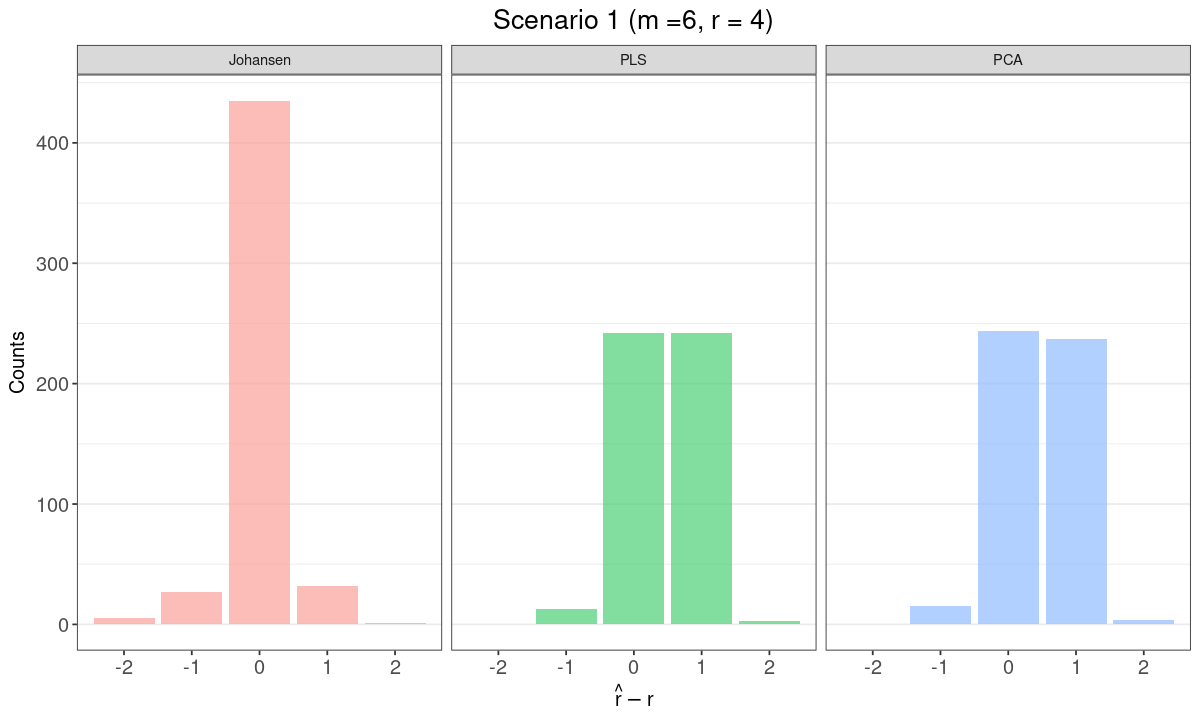

In [4]:
data_n_coint<- as.data.table(n_coint)
data_n_coint <- data_n_coint[, which(colSums(is.na(data_n_coint)) == 0), with = FALSE]

data_n_coint_melt <- melt(data_n_coint,
    variable.name = "Method",
    value.name = "AnnError"
)
data_n_coint_melt[,AnnError:=as.integer(AnnError)]
ggplot(data_n_coint_melt, aes(x = AnnError,fill=Method)) +
    geom_bar(alpha=0.7) + 
    facet_grid(~Method) +
    ggtitle(paste0("Scenario ", case," (m =",m,", r = ",r,")")) +
    xlab(TeX(r"($\hat{r}-r$)")) + mytheme +  
    scale_x_continuous(breaks = seq(min(data_n_coint_melt$AnnError), 
                                    max(data_n_coint_melt$AnnError), by = 1)) +
    ylab("Counts")+
    scale_fill_manual(values = methods_colors)+theme(legend.position = "none")


Numerical results in the *stable space dimension* estimation

In [5]:
data_n_coint_melt[,.(AnnError= mean(AnnError,na.rm=TRUE),sd = sd(AnnError,na.rm = TRUE)),by=Method]

Method,AnnError,sd
<fct>,<dbl>,<dbl>
Johansen,-0.006,0.4077948
PLS,0.470,0.5601138
PCA,0.460,0.5701317


Finally, we estimate the *stable space estimation error*, we measure that obtaining for each simulation obtaining the generalised Grassmanm distance

$$\delta(\hat{\beta},\beta).$$ 

We visualise this by boxplots

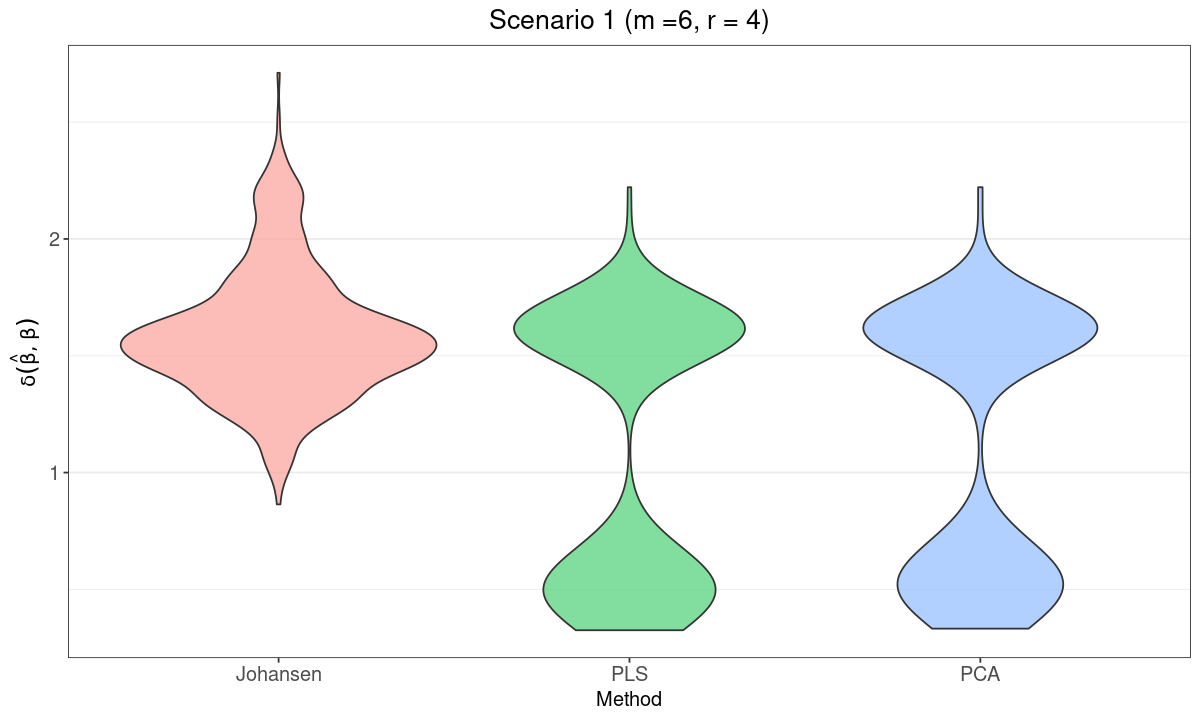

In [6]:
data_norms <- as.data.table(n_norms)
# data_norms <- data_norms[, which(colSums(is.na(data_norms)) == 0), with = FALSE]

# Create the box plot
data_norms_melt <- melt(data_norms,variable.name="Method",
                        value.name = "Norm")
ggplot(data_norms_melt, aes(x = Method, y = Norm, fill = Method)) +
  geom_violin(alpha = 0.7) +
  # stat_summary(fun = mean, geom = "point", 
  #              color = "black", size = 3) +
  # stat_summary(fun = mean, geom = "text", 
  #              aes(label = round(..y.., 2)), 
  #              vjust = -1.5, color = "black")+
  labs(
    title = paste0("Scenario ",case," (m =",m,", r = ",r,")"),
    x = "Method",
    y = TeX(r"($\delta(\hat{\beta},\beta)$)"),
  ) + mytheme +
  scale_fill_manual(values = methods_colors)+theme(legend.position = "none")


The numerical summary for the *stable space error estimation*

In [7]:
data_norms_melt[,.(Norm=mean(Norm,na.rm = TRUE),sd=sd(Norm,na.rm = TRUE)),by=Method]

Method,Norm,sd
<fct>,<dbl>,<dbl>
Johansen,1.589808,0.2777800
PLS,1.102987,0.5665486
PCA,1.121545,0.5558630


Now, we are going to proof what happen with the computation time in a high dimensional setting.

In [8]:
# Shared Sigma_eps
set.seed(seeds[1])  # for reproducibility
if (dependence) {
  Sigma_eps <- clusterGeneration::genPositiveDefMat(m, covMethod = "eigen")$Sigma
} else {
  Sigma_eps <- sigma * diag(1, m, m)
}

# Shared stable basis
set.seed(seeds[2]+r)  # shared seed for beta, beta_orto, alpha, gamma
I_m <- qr.Q(qr(matrix(rnorm(m^2), m, m)))
beta <- I_m[, 1:r]
beta_orto <- if (r < m) I_m[, (r + 1):m] else matrix(0, m, m)

# Alpha and gamma
alpha <- if (persistence == "low") runif(r, 0.1, 0.3) else runif(r, 0.3, 0.7)
gamma <- runif(ncol(beta_orto), -0.7, 0.7)

# Integration orders by case
orders <- switch(
  as.character(case),
  "1" = c(m, 0),
  "2" = c(m - 3, 2),
  stop("Unsupported case")
)
i1 <- orders[1]
i2 <- orders[2]